In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from CNN_LSTM import GatedFusionModel, VisualCNN

In [3]:
gated_model = GatedFusionModel(num_rays=107)
gated_model.load_state_dict(torch.load("ray_transformer.pth"))

<All keys matched successfully>

In [4]:
vision_model = VisualCNN(num_rays=107)
vision_model.load_state_dict(torch.load("cnn.pth"))

<All keys matched successfully>

In [5]:
X_rays_test = np.load('../data/CNN_LSTM_test_rays.npy')  # (N, T, R)
Y_pos_test =  np.load('../data/CNN_LSTM_test_pos.npy')    # (N, T, 2)
Y_vel_test =  np.load('../data/CNN_LSTM_test_vel.npy')    # (N, 2)
print("X_rays_test shape:", X_rays_test.shape)
print("Y_pos_test shape:", Y_pos_test.shape)
print("Y_vel_test shape:", Y_vel_test.shape)

Y_pos_final_test = Y_pos_test[:, -1, :]  # position at last time step

X_rays_test shape: (4701, 5, 107)
Y_pos_test shape: (4701, 5, 2)
Y_vel_test shape: (4701, 2)


In [7]:
i = np.random.randint(0, len(X_rays_test) - 1)

test_ray = torch.tensor(X_rays_test[i], dtype=torch.float32)
test_pos = torch.tensor(Y_pos_test[i], dtype=torch.float32)

print("Test ray shape:", test_ray.shape)
print("Test position shape:", test_pos.shape)

Test ray shape: torch.Size([5, 107])
Test position shape: torch.Size([5, 2])


In [8]:
true_vel = []
pred_vel = []
true_pos = []
pred_pos = []
cnn_pos = []

vision_model.eval()
gated_model.eval()
with torch.no_grad():
    idx = np.random.randint(0, len(X_rays_test) - 1, 30)

    for i in idx:
        test_ray = torch.tensor(X_rays_test[i:i+1], dtype=torch.float32)

        pos_seq = vision_model(test_ray.squeeze(0))  # (1,5,2)
        cnn_pos.append(pos_seq.numpy()[-1, :])
        prediction = gated_model(test_ray, pos_seq.unsqueeze(0)).numpy()[0]

        true_pos.append(Y_pos_final_test[i])
        true_vel.append(Y_vel_test[i])
        pred_pos.append(prediction[:2])
        pred_vel.append(prediction[2:])

In [9]:
x_coords_true_vel, y_coords_true_vel = zip(*true_vel)
x_coords_pred_vel, y_coords_pred_vel = zip(*pred_vel)
x_coords_true_pos, y_coords_true_pos = zip(*true_pos)
x_coords_pred_pos, y_coords_pred_pos = zip(*pred_pos)
x_coords_cnn_pos, y_coords_cnn_pos = zip(*cnn_pos)

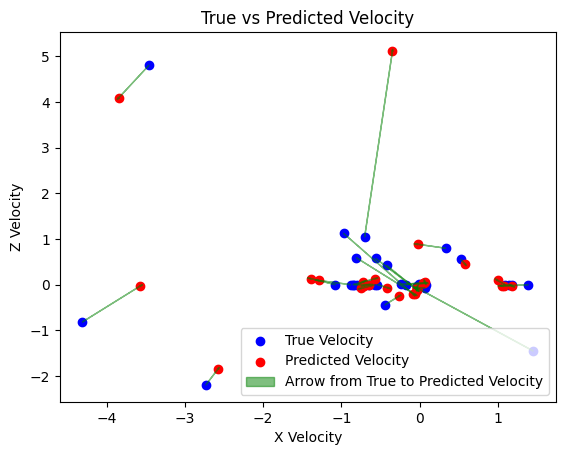

In [12]:
plt.scatter(x_coords_true_vel, y_coords_true_vel, color='blue', label='True Velocity')
plt.scatter(x_coords_pred_vel, y_coords_pred_vel, color='red', label='Predicted Velocity')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_vel[i], y_coords_true_vel[i], x_coords_pred_vel[i]-x_coords_true_vel[i], y_coords_pred_vel[i]-y_coords_true_vel[i], 
              head_width=0.02, head_length=0.05, fc='green', ec='green', alpha=0.5, label="Arrow from True to Predicted Velocity" if i == 0 else "")
plt.title("True vs Predicted Velocity")
plt.xlabel("X Velocity")
plt.ylabel("Z Velocity")
plt.legend()


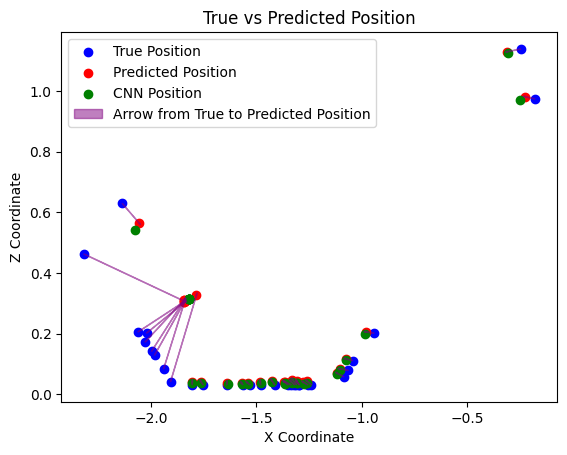

In [11]:
plt.scatter(x_coords_true_pos, y_coords_true_pos, color='blue', label='True Position')
plt.scatter(x_coords_pred_pos, y_coords_pred_pos, color='red', label='Predicted Position')
plt.scatter(x_coords_cnn_pos, y_coords_cnn_pos, color='green', label='CNN Position')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_pos[i], y_coords_true_pos[i], x_coords_pred_pos[i]-x_coords_true_pos[i], y_coords_pred_pos[i]-y_coords_true_pos[i], 
              head_width=0.005, head_length=0.01, fc='purple', ec='purple', alpha=0.5, label="Arrow from True to Predicted Position" if i == 0 else "")
plt.title("True vs Predicted Position")
plt.xlabel("X Coordinate")
plt.ylabel("Z Coordinate")
plt.legend()